In [1]:


import time
import os
import numpy as np
# 定义矩阵乘法


def apply_clover(Vin, op):
    Vout = np.zeros(Vin.shape, dtype=Vin.dtype)
    Vout = np.einsum('...ab,...b->...a', op.clover, Vin)
    return Vout


def apply_hopping_x_p(Vin, op):
    Vout = np.zeros(Vin.shape, dtype=Vin.dtype)
    Vout = (np.einsum('...ab,...b->...a',
            op.hopping[0, :], np.roll(Vin, -1, axis=0)))
    return Vout


def apply_hopping_x_m(Vin, op):
    Vout = np.zeros(Vin.shape, dtype=Vin.dtype)
    Vout = (np.einsum('...ab,...b->...a',
            op.hopping[1, :], np.roll(Vin, 1, axis=0)))
    return Vout


def apply_hopping_y_p(Vin, op):
    Vout = np.zeros(Vin.shape, dtype=Vin.dtype)
    Vout = (np.einsum('...ab,...b->...a',
            op.hopping[2, :], np.roll(Vin, -1, axis=1)))
    return Vout


def apply_hopping_y_m(Vin, op):
    Vout = np.zeros(Vin.shape, dtype=Vin.dtype)
    Vout = (np.einsum('...ab,...b->...a',
            op.hopping[3, :], np.roll(Vin, 1, axis=1)))
    return Vout


def apply_hopping(Vin, op):
    Vout = np.zeros(Vin.shape, dtype=Vin.dtype)
    Vout = apply_hopping_x_p(Vin, op) + apply_hopping_x_m(Vin, op) + \
        apply_hopping_y_p(Vin, op) + apply_hopping_y_m(Vin, op)
    return Vout


def apply_mat(Vin, op):
    Vin = apply_clover(Vin, op) + apply_hopping(Vin, op)
    return Vin
# 格点参数


class operator_para:
    nx = 0
    ny = 0
    nc = 0
    volume = 0
    if_fine = 0
    hopping = np.zeros((4, nx, ny, nc, nc*2)).view(np.complex128)
    clover = np.zeros((nx, ny, nc, nc*2)).view(np.complex128)

    def __init__(self, nx, ny, nc=2, U=0, if_fine=0):
        self.nx = nx
        self.ny = ny
        self.nc = nc
        self.U = U
        self.volume = nx*ny
        self.if_fine = if_fine
        self.hopping = np.zeros((4, nx, ny, nc, nc*2)).view(np.complex128)
        self.clover = np.zeros((nx, ny, nc, nc*2)).view(np.complex128)
        # print(f"(nx, ny, nc, nc):{(nx, ny, nc, nc)}")
        # print(f"self.clover.shape:{self.clover.shape}")
        # print(f"self.clover.dtype:{self.clover.dtype}")
        # exit()
        for i in range(0, self.nc):
            self.clover[:, :, i, i] = 1
        if self.if_fine != 0:
            print(self.hopping.shape)
            ma = -0.4  # -0.4375
            kappa = -1/(2*(ma + 4))
            self.hopping[0, :] = kappa*np.roll(self.U[0, :], -1, axis=0)  # x+
            self.hopping[1, :] = kappa * \
                np.conj(self.U[0, :]).transpose(0, 1, 3, 2)  # x-
            self.hopping[2, :] = kappa*np.roll(self.U[1, :], -1, axis=1)  # y+
            self.hopping[3, :] = kappa * \
                np.conj(self.U[1, :]).transpose(0, 1, 3, 2)  # y-


# 生成组态U
# SU(2)
# 定义 Pauli 矩阵
sigma1 = np.array([[0, 1], [1, 0]], dtype=complex)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma3 = np.array([[1, 0], [0, -1]], dtype=complex)
eye = np.array([[1, 0], [0, 1]], dtype=complex)
pauli = [sigma1, sigma2, sigma3]


def generate_E_m_su2_u1():
    a = np.random.randn(1)  # U(1)
    E_m_su2 = eye-sigma1
    return a*E_m_su2


def generate_E_p_su2_u1():
    a = np.random.randn(1)  # U(1)
    E_m_su2 = eye+sigma1
    return a*E_m_su2


def generate_E_m_su2_u1_2():
    a = np.random.randn(1)  # U(1)
    E_m_su2 = eye-sigma2
    return a*E_m_su2


def generate_E_p_su2_u1_2():
    a = np.random.randn(1)  # U(1)
    E_m_su2 = eye+sigma2
    return a*E_m_su2


def generate_large_matrix(x, y, nc):
    """
    生成形状为 (x, y, 2, 2) 的矩阵，每个 (2, 2) 子矩阵是随机的 SU(2) 矩阵。
    参数：
        x (int): 第一维的大小
        y (int): 第二维的大小
    返回：
        numpy.ndarray: 形状为 (x, y, 2, 2) 的复数矩阵
    """
    # 初始化大矩阵
    large_matrix = np.zeros((4, x, y, nc, nc), dtype=np.complex128)
    if (nc == 2):
        large_matrix[0, :, :] = generate_E_m_su2_u1()
        large_matrix[1, :, :] = generate_E_p_su2_u1()
        large_matrix[2, :, :] = generate_E_m_su2_u1_2()
        large_matrix[3, :, :] = generate_E_p_su2_u1_2()
    return large_matrix
# 生成或读取组态U


def load_or_generate_U(nx, ny, nc, folder_path="."):
    """
    检查文件夹下是否有U_nx_ny_nc.npy文件，若存在则读取，否则生成并保存。
    参数：
    nx, ny, nc: 用于构造文件名和生成U的参数
    folder_path: 文件夹路径，默认为当前目录
    返回：
    U: CuPy complex128数组
    """
    # 构造文件名
    file_name = f"U_{nx}_{ny}_{nc}.npy"
    file_path = os.path.join(folder_path, file_name)
    # 检查文件是否存在
    if os.path.exists(file_path):
        print(f"找到文件 {file_name}，正在加载...")
        # 读取NumPy数组并转换为CuPy数组
        U_np = np.load(file_path)
        U = np.array(U_np, dtype=np.complex128)
    else:
        print(f"未找到文件 {file_name}，正在生成...")
        # 调用aaa函数生成U
        U = generate_large_matrix(nx, ny, nc)
        # 确保U是complex128类型
        U = U.astype(np.complex128)
        # 将CuPy数组转换为NumPy数组以保存
        U_np = U
        # 保存到文件
        np.save(file_path, U_np)
        print(f"已保存文件 {file_name}")
    return U


class cg_info:
    count = 0
    norm_r = 0
    r = 0
    if_max_iter = 0


def bicgstab(b, x0=None, op=None, max_iter=3000, tol=1e-8, if_info=0, info=cg_info(), relative_tol=0):
    """
    使用BiCGSTAB方法求解 Ax = b，其中矩阵A的乘法操作被替换为 apply_mat(V, op)。
    参数：
    - lattice: 具有 apply_mat 方法的 lattice 对象。
    - b: 右侧向量。
    - x0: 初始解（默认为零向量）。
    - op: apply_mat 的操作参数。
    - max_iter: 最大迭代次数。
    - tol: 收敛容差。
    返回：
    - x: 解向量。
    """
    # 初始化解向量 x
    if x0 is None:
        x = np.zeros_like(b)
    else:
        x = x0.copy()
    # 计算初始残差 r = b - Ax
    r = b - apply_mat(x, op)
    if relative_tol != 0:
        tol = np.vdot(r, r)*relative_tol
    # print(r)
    r0 = r.copy()  # 保存初始残差 r0
    p = r.copy()   # 初始化搜索方向 p
    alpha = 1
    count = 0
    # 主迭代循环
    for k in range(max_iter):
        count += 1
        # 计算 Ap = A * p
        Ap = apply_mat(p, op)
        # 计算步长 alpha
        alpha = np.vdot(r0, r) / np.vdot(r0, Ap)
        # print("alpha = ", alpha)
        x += alpha * p
        # 更新中间残差 r_1 = r - alpha * Ap
        r_1 = r - alpha * Ap
        # 检查是否收敛
        if if_info != 0:
            print(np.vdot(r_1, r_1))
        if np.vdot(r_1, r_1) < tol:
            if if_info != 0:
                print("count = ", count)
            info.count = count
            info.norm_r = np.vdot(r_1, r_1)
            info.r = r_1
            return x
        # 计算 t = A * r
        t = apply_mat(r, op)
        # 计算 omega
        omega = np.vdot(t, r) / np.vdot(t, t)
        # 更新解 x
        x += omega * r_1
        # 更新残差 r = r_1 - omega * t
        r_1 = r_1 - omega * apply_mat(r_1, op)
        # 检查是否收敛
        if np.vdot(r, r) < tol:
            if if_info != 0:
                print("count = ", count)
            info.count = count
            info.norm_r = np.vdot(r_1, r_1)
            info.r = r_1
            return x
        # 计算 beta
        beta = (np.vdot(r_1, r_1) / np.vdot(r, r))
        # 更新搜索方向 p
        p = r_1 + alpha*beta/omega*p - alpha*beta*Ap
        r = r_1
    # 如果未收敛，抛出错误
    print("over max_iter")
    info.if_max_iter = 1
    return x


class mg:
    blocksize = [2, 2, 2, 2, 2, 2]  # 每一层的单个方向的压缩程度
    coarse_dof = [4, 4, 8, 12, 12, 12, 12, 12]  # 新一层的内禀维度
    R_null_vec = []
    mg_ops = []
    coarse_map = []
    fine_sites_per_coarse_list = []
    convergence_history = []
    # 生成近零空间向量

    def near_null_vec(self, P_null_vec_coarse, coarse_dof, coarse_op, info=cg_info()):
        for i in range(0, coarse_dof):
            # 施密特正交化
            for k in range(0, i):
                P_null_vec_coarse[i, :, :, :] -= np.vdot((P_null_vec_coarse[k, :, :, :]), P_null_vec_coarse[i, :, :, :])/np.vdot(
                    (P_null_vec_coarse[k, :, :, :]), P_null_vec_coarse[k, :, :, :])*P_null_vec_coarse[k, :, :, :]
            # Ar
            Ar = apply_mat(P_null_vec_coarse[i, :, :, :], coarse_op)
            # -Ar
            Ar = -Ar
            # x = (A^-1)*(-Ar)
            x = bicgstab(Ar, op=coarse_op, tol=5e-5, info=info)
            # V = x+r
            P_null_vec_coarse[i, :, :, :] += x
            # 施密特正交化
            for k in range(0, i):
                P_null_vec_coarse[i, :, :, :] -= np.vdot((P_null_vec_coarse[k, :, :, :]), P_null_vec_coarse[i, :, :, :])/np.vdot(
                    (P_null_vec_coarse[k, :, :, :]), P_null_vec_coarse[k, :, :, :])*P_null_vec_coarse[k, :, :, :]
            P_null_vec_coarse[i, :] = P_null_vec_coarse[i, :] / \
                np.sqrt(
                    np.vdot((P_null_vec_coarse[i, :]), P_null_vec_coarse[i, :]))
            print(
                f"(apply_mat(P_null_vec_coarse[i, :, :, :], coarse_op)/P_null_vec_coarse[i, :, :, :]).flatten()[:10]:{(apply_mat(P_null_vec_coarse[i, :, :, :], coarse_op)/P_null_vec_coarse[i, :, :, :]).flatten()[:10]}")
        return P_null_vec_coarse

    def vol_index_dof_to_cv_index(self, i, i_dof, coarse_op):
        return coarse_op.nc*i + i_dof

    def index_to_coord(self, ptr, coarse_op):
        y_coarse = ptr % coarse_op.ny
        x_coarse = ptr // coarse_op.ny
        return x_coarse, y_coarse
    # 网格物理地址与内存地址转化

    def coord_to_index(self, coords, coarse_op, i):
        ptr = (coarse_op.ny*coords[0] + coords[1])*coarse_op.nc + i
        return ptr

    def zeros_like_fermi(self, level):
        fermi_out = np.random.rand(
            self.mg_ops[level].nx, self.mg_ops[level].ny, self.mg_ops[level].nc*2).view(np.complex128)
        fermi_out = np.zeros_like(fermi_out)
        return fermi_out
    '''
    建立粗网格与细网格之间的对应关系
    '''

    def build_mapping(self, map_id, fine_op, coarse_op):
        print("Buliding map...")
        for i in range(0, coarse_op.volume):
            x_coarse, y_coarse = self.index_to_coord(i, coarse_op)
            coarse_coords = [x_coarse, y_coarse]
            coords = [0, 0]
            blocksizes = int(fine_op.nx/coarse_op.nx)
            count = [0]
            self.recursive_site_build(
                map_id, coarse_coords, coords, 0, count, blocksizes, fine_op, i)
        print("Buliding map finished")
    '''
    build_mapping用到的递归函数
    '''

    def recursive_site_build(self, map_id, coarse_coords, coords, step, count, blocksizes, fine_op, fine_ptr):
        if (step < 2):
            for i in range(coarse_coords[step]*blocksizes, (coarse_coords[step]+1)*blocksizes):
                coords[step] = i
                self.recursive_site_build(
                    map_id, coarse_coords, coords, step+1, count, blocksizes, fine_op, fine_ptr)
        else:
            for i in range(0, fine_op.nc):
                self.coarse_map[map_id][fine_ptr][count[0]
                                                  ] = self.coord_to_index(coords, fine_op, i)
                count[0] = count[0] + 1

    def initialize_random_vector(self, v):
        v.real, v.imag = np.random.randn(v.size).astype(
            v.real.dtype), np.random.randn(v.size).astype(v.imag.dtype)
        norm = np.linalg.norm(v)
        if norm > 0:
            np.divide(v, norm, out=v)
        return v

    def restrict_f2c(self, fine_level, fermi_in, fermi_out):
        fine_sites_per_coarse = self.fine_sites_per_coarse_list[fine_level]
        nevc = self.coarse_dof[fine_level]
        fermi_in = fermi_in.reshape(-1)
        fermi_out = fermi_out.reshape(-1)
        for i in range(0, self.mg_ops[fine_level+1].volume):
            for i_dof in range(0, nevc):
                cv_index = self.vol_index_dof_to_cv_index(
                    i, i_dof, self.mg_ops[fine_level+1])
                for j in range(0, fine_sites_per_coarse):
                    fermi_out[cv_index] += np.conj(self.R_null_vec[fine_level][i_dof]
                                                   [self.coarse_map[fine_level][i][j]])*fermi_in[self.coarse_map[fine_level][i][j]]

    def prolong_c2f(self, fine_level, fermi_in, fermi_out):
        fine_sites_per_coarse = self.fine_sites_per_coarse_list[fine_level]
        nevc = self.coarse_dof[fine_level]
        fermi_in = fermi_in.reshape(-1)
        fermi_out = fermi_out.reshape(-1)
        for i in range(0, self.mg_ops[fine_level+1].volume):
            for i_dof in range(0, nevc):
                cv_index = self.vol_index_dof_to_cv_index(
                    i, i_dof, self.mg_ops[fine_level+1])
                for j in range(0, fine_sites_per_coarse):
                    fermi_out[self.coarse_map[fine_level][i][j]
                              ] += self.R_null_vec[fine_level][i_dof][self.coarse_map[fine_level][i][j]]*fermi_in[cv_index]

    def local_orthogonalization(self, fine_level, nevc, fine_sites_per_coarse):
        for i in range(0, self.mg_ops[fine_level+1].volume):
            for i_dof in range(0, nevc):
                for k in range(0, i_dof):
                    k_dot = 0
                    k_i_dof_dot = 0
                    for j in range(0, fine_sites_per_coarse):
                        k_dot += np.conj(self.R_null_vec[fine_level][k][self.coarse_map[fine_level][i][j]]) * \
                            self.R_null_vec[fine_level][k][self.coarse_map[fine_level][i][j]]
                        k_i_dof_dot += np.conj(self.R_null_vec[fine_level][k][self.coarse_map[fine_level][i][j]]) * \
                            self.R_null_vec[fine_level][i_dof][self.coarse_map[fine_level][i][j]]
                    for j in range(0, fine_sites_per_coarse):
                        self.R_null_vec[fine_level][i_dof][self.coarse_map[fine_level][i][j]
                                                           ] -= self.R_null_vec[fine_level][k][self.coarse_map[fine_level][i][j]] * k_i_dof_dot / k_dot
                i_dof_dot = 0
                for j in range(0, fine_sites_per_coarse):
                    i_dof_dot += np.conj(self.R_null_vec[fine_level][i_dof][self.coarse_map[fine_level][i][j]]) * \
                        self.R_null_vec[fine_level][i_dof][self.coarse_map[fine_level][i][j]]
                for j in range(0, fine_sites_per_coarse):
                    self.R_null_vec[fine_level][i_dof][self.coarse_map[fine_level]
                                                       [i][j]] /= np.sqrt(i_dof_dot)

    def __init__(self, fine_op, n_refine, ifeigen=0):
        self.n_refine = n_refine
        self.fine_op = fine_op
        U = self.fine_op.U
        nx = self.fine_op.nx
        ny = self.fine_op.ny
        nc = self.fine_op.nc
        if (ifeigen == 0):
            print("搭建多重网格...")
            self.mg_ops.append(fine_op)
            for i in range(0, n_refine):
                print("当前层： ", i)
                print("创造近零空间向量...")
                for s in range(10):
                    info_null_vec = cg_info()
                    P_null_vec_coarse = np.random.rand(
                        self.coarse_dof[i], nx, ny, nc*2).view(np.complex128)
                    P_null_vec_coarse = self.near_null_vec(
                        P_null_vec_coarse, self.coarse_dof[i], self.mg_ops[i], info=info_null_vec)
                    # P_null_vec_coarse = self.initialize_random_vector(
                    #     v=P_null_vec_coarse.flatten()).reshape(P_null_vec_coarse.shape)  # just for test
                    if (info_null_vec.if_max_iter == 0):
                        break
                P_null_vec_coarse = P_null_vec_coarse.reshape(
                    P_null_vec_coarse.shape[0], -1)
                self.R_null_vec.append(P_null_vec_coarse)
                print("近零空间向量创造完毕")
                rand_fermi = np.random.rand(nx, ny, nc*2).view(np.complex128)
                rand_fermi = np.zeros_like(rand_fermi)
                rand_fermi = np.ones_like(rand_fermi)
                nx = int(nx/self.blocksize[i])
                ny = int(ny/self.blocksize[i])
                nc_c = nc
                nc = int(self.coarse_dof[i])
                map = [[int(0)]*int(self.blocksize[i] *
                                    self.blocksize[i]*nc_c)] * int(nx*ny)
                fine_sites_per_coarse = int(
                    self.blocksize[i]*self.blocksize[i]*nc_c)
                self.fine_sites_per_coarse_list.append(fine_sites_per_coarse)
                map = np.array(map)
                self.coarse_map.append(map)
                coarse_op = operator_para(nx, ny, nc)
                self.mg_ops.append(coarse_op)
                self.build_mapping(i, self.mg_ops[i], self.mg_ops[i+1])
                self.local_orthogonalization(
                    i, self.coarse_dof[i], fine_sites_per_coarse)
                fermi_out = np.random.rand(nx, ny, nc*2).view(np.complex128)
                fermi_out = self.zeros_like_fermi(i+1)
                fermi_out = np.zeros_like(fermi_out)
                fermi_out = fermi_out
                fermi_out_r = np.zeros_like(rand_fermi)
                print("生成更粗一层对角元与非对角元...")
                ################################# transfer ######################################
                self.mg_ops[i +
                            1].clover = np.zeros_like(self.mg_ops[i+1].clover)
                # clover
                for color in range(0, self.mg_ops[i+1].nc):
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[:, :, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_clover(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].clover[:, :, :,
                                            color] = fermi_tmp_coarse[:, :, :]
                # wilson
                self.mg_ops[i +
                            1].hopping = np.zeros_like(self.mg_ops[i+1].hopping)
                for color in range(0, self.mg_ops[i+1].nc):
                    # xp=even
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[0:-1:2, :, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_x_p(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[0, 1::2, :, :,
                                             color] = fermi_tmp_coarse[1::2, :, :]
                    self.mg_ops[i+1].clover[0:-1:2, :, :,
                                            color] += fermi_tmp_coarse[0:-1:2, :, :]
                    # xp=odd
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[1::2, :, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_x_p(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[0, 0:-1:2, :, :,
                                             color] = fermi_tmp_coarse[0:-1:2, :, :]
                    self.mg_ops[i+1].clover[1::2, :, :,
                                            color] += fermi_tmp_coarse[1::2, :, :]
                    # xm=even
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[0:-1:2, :, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_x_m(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[1, 1::2, :, :,
                                             color] = fermi_tmp_coarse[1::2, :, :]
                    self.mg_ops[i+1].clover[0:-1:2, :, :,
                                            color] += fermi_tmp_coarse[0:-1:2, :, :]
                    # xm=odd
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[1::2, :, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_x_m(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[1, 0:-1:2, :, :,
                                             color] = fermi_tmp_coarse[0:-1:2, :, :]
                    self.mg_ops[i+1].clover[1::2, :, :,
                                            color] += fermi_tmp_coarse[1::2, :, :]
                    # yp=even
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[:, 0:-1:2, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_y_p(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[2, :, 1::2, :,
                                             color] = fermi_tmp_coarse[:, 1::2, :]
                    self.mg_ops[i+1].clover[:, 0:-1:2, :,
                                            color] += fermi_tmp_coarse[:, 0:-1:2, :]
                    # yp=odd
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[:, 1::2, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_y_p(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[2, :, 0:-1:2, :,
                                             color] = fermi_tmp_coarse[:, 0:-1:2, :]
                    self.mg_ops[i+1].clover[:, 1::2, :,
                                            color] += fermi_tmp_coarse[:, 1::2, :]
                    # ym=even
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[:, 0:-1:2, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_y_m(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[3, :, 1::2, :,
                                             color] = fermi_tmp_coarse[:, 1::2, :]
                    self.mg_ops[i+1].clover[:, 0:-1:2, :,
                                            color] += fermi_tmp_coarse[:, 0:-1:2, :]
                    # ym=odd
                    fermi_tmp_coarse = np.zeros_like(fermi_out)
                    fermi_tmp_fine = np.zeros_like(fermi_out_r)
                    fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                    fermi_tmp_coarse[:, 1::2, color] = 1
                    self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                    fermi_tmp_Afine = apply_hopping_y_m(
                        fermi_tmp_fine, self.mg_ops[i])
                    fermi_tmp_coarse = np.zeros_like(fermi_tmp_coarse)
                    self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse)
                    self.mg_ops[i+1].hopping[3, :, 0:-1:2, :,
                                             color] = fermi_tmp_coarse[:, 0:-1:2, :]
                    self.mg_ops[i+1].clover[:, 1::2, :,
                                            color] += fermi_tmp_coarse[:, 1::2, :]
                fermi_tmp_coarse = np.zeros_like(fermi_out)
                fermi_tmp_fine = np.zeros_like(fermi_out_r)
                fermi_tmp_Afine = np.zeros_like(fermi_out_r)
                fermi_tmp_coarse_n = np.zeros_like(fermi_out)
                fermi_tmp_coarse_t = np.zeros_like(fermi_out)
                fermi_tmp_coarse[:, :, 0] = 1
                fermi_tmp_coarse_n = apply_mat(
                    fermi_tmp_coarse, self.mg_ops[i+1])
                self.prolong_c2f(i, fermi_tmp_coarse, fermi_tmp_fine)
                fermi_tmp_Afine = apply_mat(
                    fermi_tmp_fine, self.mg_ops[i])
                self.restrict_f2c(i, fermi_tmp_Afine, fermi_tmp_coarse_t)
                print("dif = ", np.linalg.norm(
                    fermi_tmp_coarse_n-fermi_tmp_coarse_t))

    def mg_bicgstab_recursive(self, b, max_iter=300, tol=1e-10, if_info=1, info=cg_info(), level=0, relative_tol=0):
        x = np.zeros_like(b)
        if level < self.n_refine+1:
            # 计算初始残差 r = b - Ax
            r = b - apply_mat(x, self.mg_ops[level])
            if relative_tol != 0:
                tol = np.sqrt(np.vdot(r, r))*relative_tol
            r0 = r.copy()  # 保存初始残差 r0
            p = r.copy()   # 初始化搜索方向 p
            alpha = 1
            count = 0
            if if_info != 0:
                print(" "*(level), "level = ", level, np.sqrt(np.vdot(r, r)))
            # 主迭代循环
            for k in range(max_iter):
                count += 1
                # 计算 Ap = A * p
                Ap = apply_mat(p, self.mg_ops[level])
                # 计算步长 alpha
                alpha = np.vdot((r0), r) / np.vdot((r0), Ap)
                x += alpha * p
                # 更新中间残差 r_1 = r - alpha * Ap
                r_1 = r - alpha * Ap
                # 检查是否收敛
                if if_info != 0:
                    print(" "*(level), "level = ", level,
                          np.sqrt(np.vdot(r_1, r_1)))
                if np.sqrt(np.vdot(r_1, r_1)) < tol:
                    if if_info != 0:
                        print(" "*(level), "level = ", level, "RelRes", np.sqrt(
                            np.vdot(r_1, r_1))/np.sqrt(np.vdot(r0, r0)))
                    info.count = count
                    info.norm_r = np.sqrt(np.vdot(r_1, r_1))
                    info.r = r_1
                    return x
                # 计算 t = A * r
                t = apply_mat(r, self.mg_ops[level])
                # 计算 omega
                omega = np.vdot((t), r) / np.vdot((t), t)
                # 更新解 x
                x += omega * r_1
                # 更新残差 r = r_1 - omega * t
                r_1 = r_1 - omega * apply_mat(r_1, self.mg_ops[level])
                if level == 0:
                    r_norm = np.linalg.norm(b - apply_mat(x, self.mg_ops[0]))
                    self.convergence_history.append(r_norm)
                    print(
                        f"{k}_B:np.linalg.norm(b - apply_mat(x, self.mg_ops[0])):{r_norm}")
                if level < self.n_refine:
                    # 下潜
                    r_coarse = self.zeros_like_fermi(level=level+1)
                    self.restrict_f2c(level, r_1, r_coarse)
                    # 递归
                    info_c = cg_info()
                    relative_tol = 0.25
                    if level+1 == self.n_refine:
                        e_coarse = self.mg_bicgstab_recursive(
                            r_coarse, level=level+1, info=info_c, relative_tol=0.1, if_info=0, max_iter=100)
                    else:
                        e_coarse = self.mg_bicgstab_recursive(
                            r_coarse, level=level+1, info=info_c, relative_tol=0.25, if_info=1, max_iter=100)
                    print(" "*(level+1), "level", level +
                          1, " ", "iter", info_c.count)
                    # 上浮
                    e0_fine = self.zeros_like_fermi(level=level)
                    self.prolong_c2f(level, e_coarse, e0_fine)
                    if info_c.if_max_iter == 0:  # ?
                        x = x + e0_fine
                        r_1 = b - apply_mat(x, self.mg_ops[level])
                if level == 0:
                    r_norm = np.linalg.norm(b - apply_mat(x, self.mg_ops[0]))
                    self.convergence_history.append(r_norm)
                    print(
                        f"{k}_F:np.linalg.norm(b - apply_mat(x, self.mg_ops[0])):{r_norm}")
                # 检查是否收敛
                if np.sqrt(np.vdot(r_1, r_1)) < tol:
                    if if_info != 0:
                        print(" "*(level), "level = ", level, "RelRes", np.sqrt(
                            np.vdot(r_1, r_1))/np.sqrt(np.vdot(r0, r0)))
                    info.count = count
                    info.norm_r = np.sqrt(np.vdot(r_1, r_1))
                    info.r = r_1
                    return x
                # 计算 beta
                beta = (np.vdot((r_1), r_1) / np.vdot((r), r))
                # 更新搜索方向 p
                p = r_1 + alpha*beta/omega*p - alpha*beta*Ap
                r = r_1
            # 如果未收敛，抛出错误
            print(" "*(level), "level", level, "over max_iter")
            info.if_max_iter = 1
            return x
        if level == 0:
            print("level = ", level, "   ")

    def mg_bicgstab(self, b, max_iter=3000, tol=1e-10,  info=cg_info()):

        X = self.mg_bicgstab_recursive(
            b, max_iter=max_iter, tol=tol, info=info, level=0, relative_tol=0)
        print("mg_bicgstab_recursive.count = ", info.count)

        return X

    def plot(self):
        import matplotlib.pyplot as plt
        import numpy as np
        np.Inf = np.inf
        plt.figure(figsize=(10, 6))
        plt.title(
            f"(self.mg_ops[0].nx,self.mg_ops[0].ny,self.mg_ops[0].nc:{self.mg_ops[0].nx,self.mg_ops[0].ny,self.mg_ops[0].nc})convergence_history(self.coarse_dof:{self.coarse_dof})", fontsize=16)
        plt.semilogy(range(1, len(self.convergence_history) + 1),
                     self.convergence_history, 'b-o', markersize=4, linewidth=2)
        plt.xlabel(
            f"Iteration", fontsize=12)
        plt.ylabel('Residual Norm', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

In [2]:
nx = 64
ny = nx
nc = 2
# 生成随即组态
U = load_or_generate_U(nx, ny, nc, "./U_data/")
print("生成的矩阵形状：", U.shape)
# 确定格点
fine_op = operator_para(nx, ny, nc, U=U, if_fine=1)
V = np.random.rand(nx, ny, nc*2).view(np.complex128)
x0 = np.random.rand(nx, ny, nc*2).view(np.complex128)
Vout = apply_mat(V, fine_op)
start_time = time.perf_counter()
V0 = bicgstab(Vout, x0, op=fine_op, if_info=1, tol=1e-8)
end_time = time.perf_counter()


找到文件 U_64_64_2.npy，正在加载...
生成的矩阵形状： (4, 64, 64, 2, 2)
(4, 64, 64, 2, 2)
(327.3356692705787+0j)
(9.130302685610761+0j)
(1.8759241821053576+0j)
(0.3983187361629999+0j)
(0.1908627521613403+0j)
(0.3015167936924525+0j)
(0.5764337122544125+0j)
(0.13871549338571562+0j)
(0.029249919833112387+0j)
(0.06042004855665971+0j)
(0.01137461288969946+0j)
(0.009472033451676538+0j)
(0.006097495904480162+0j)
(0.005797752635752274+0j)
(0.002994994434829204+0j)
(0.00266765631209608+0j)
(0.004495004889913865+0j)
(0.0016217526119065638+0j)
(0.0012697415866975794+0j)
(0.0006445424516335208+0j)
(0.018226509493293845+0j)
(0.0001763449745442767+0j)
(0.00016290954003037576+0j)
(0.00011143613341437806+0j)
(9.576214386896575e-05+0j)
(9.428404804566048e-05+0j)
(2.509461494316112e-05+0j)
(2.478023298605006e-05+0j)
(2.223950539016992e-05+0j)
(1.6372274624253393e-05+0j)
(1.5053857009572462e-05+0j)
(1.1378563007684847e-05+0j)
(1.0695065149055311e-05+0j)
(9.8898168830549e-06+0j)
(9.477129261716781e-06+0j)
(9.22155202456033

In [3]:

print(f"Execution time: {end_time - start_time} seconds")
my_mg = mg(fine_op, 3)


Execution time: 0.07135472100344487 seconds
搭建多重网格...
当前层：  0
创造近零空间向量...
(apply_mat(P_null_vec_coarse[i, :, :, :], coarse_op)/P_null_vec_coarse[i, :, :, :]).flatten()[:10]:[ 0.00944848+5.16795391e-05j  0.00749532+2.52010627e-04j
  0.0168618 +1.66653280e-03j  0.01348316+3.21751405e-03j
  0.01007265+5.75300811e-04j  0.01159777+4.45999729e-03j
 -0.00240728-1.76896901e-03j  0.01273695-1.20310056e-02j
  0.01070917-1.03667039e-03j  0.0095165 +1.03439540e-03j]
(apply_mat(P_null_vec_coarse[i, :, :, :], coarse_op)/P_null_vec_coarse[i, :, :, :]).flatten()[:10]:[0.03062856+0.00580179j 0.03098028+0.00571153j 0.00025538+0.00794082j
 0.00015792+0.00788219j 0.0061189 -0.00548635j 0.0061755 -0.00569269j
 0.00746544-0.0049049j  0.00750905-0.00471721j 0.013757  +0.00127706j
 0.01371933+0.00110286j]
(apply_mat(P_null_vec_coarse[i, :, :, :], coarse_op)/P_null_vec_coarse[i, :, :, :]).flatten()[:10]:[0.01155606-2.17040914e-04j 0.01156703-3.04724205e-04j
 0.01070292-6.05669679e-04j 0.01064612-5.07660220e-04

 level =  0 (134.45820147283388+0j)
 level =  0 (15.168969099638543+0j)
0_B:np.linalg.norm(b - apply_mat(x, self.mg_ops[0])):7.45326077399652
  level =  1 (4.241004575009028+0j)
  level =  1 (2.1149776296925897+0j)
   level =  2 (0.7345803115173668+0j)
   level =  2 (0.24752392023171635+0j)
    level 3   iter 8
   level =  2 (0.12799272535578562+0j)
   level =  2 RelRes (0.17423925382835373+0j)
   level 2   iter 2
  level =  1 (1.6569214816049085+0j)
   level =  2 (0.2842799037631149+0j)
   level =  2 (0.12305062536874847+0j)
    level 3   iter 8
   level =  2 (0.16689188112457423+0j)
    level 3   iter 6
   level =  2 RelRes (0.1406916023887102+0j)
   level 2   iter 2
  level =  1 RelRes (0.18002786587689107+0j)
  level 1   iter 2
0_F:np.linalg.norm(b - apply_mat(x, self.mg_ops[0])):6.209956690452691
 level =  0 (0.7421726730932706+0j)
1_B:np.linalg.norm(b - apply_mat(x, self.mg_ops[0])):0.6095154693630035
  level =  1 (0.5748263015094379+0j)
  level =  1 (0.2629687013240795+0j)
   le

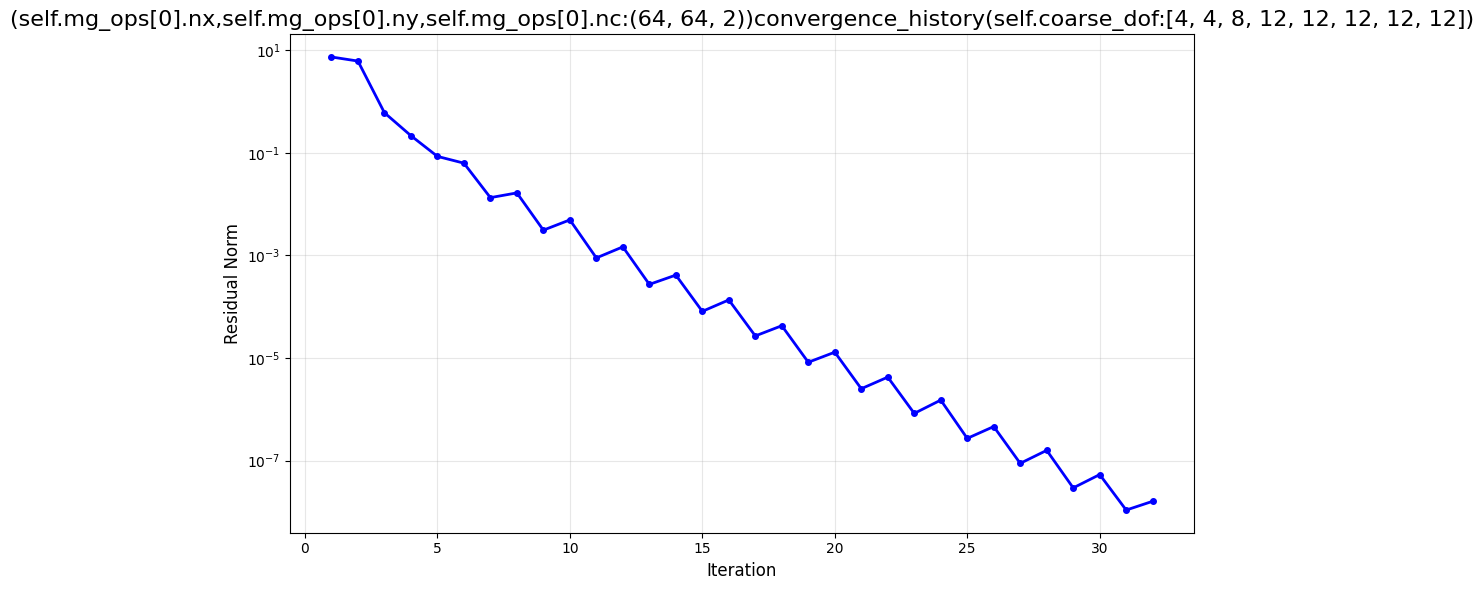

In [4]:


start_time = time.perf_counter()
V1 = my_mg.mg_bicgstab(Vout, tol=1e-8)
end_time = time.perf_counter()
my_mg.plot()
print(f"Execution time: {end_time - start_time} seconds")
print(V[0, 0, 0] - V1[0, 0, 0])
print(V[0, 0, 0] - V0[0, 0, 0])



In [5]:
for i in range(len(my_mg.mg_ops)):
    print(f"my_mg.mg_ops[{i}].nx:{my_mg.mg_ops[i].nx}")
    print(f"my_mg.mg_ops[{i}].ny:{my_mg.mg_ops[i].ny}")
    print(f"my_mg.mg_ops[{i}].nc:{my_mg.mg_ops[i].nc}")

my_mg.mg_ops[0].nx:64
my_mg.mg_ops[0].ny:64
my_mg.mg_ops[0].nc:2
my_mg.mg_ops[1].nx:32
my_mg.mg_ops[1].ny:32
my_mg.mg_ops[1].nc:4
my_mg.mg_ops[2].nx:16
my_mg.mg_ops[2].ny:16
my_mg.mg_ops[2].nc:4
my_mg.mg_ops[3].nx:8
my_mg.mg_ops[3].ny:8
my_mg.mg_ops[3].nc:8


In [6]:
index=-1

In [7]:
len(my_mg.mg_ops)

4

In [8]:
len(my_mg.R_null_vec)

3

In [9]:
my_mg.R_null_vec[-1]

array([[-0.19230583-0.17342454j, -0.25844513-0.21617498j,
        -0.0061318 +0.08725941j, ..., -0.17265968-0.21189529j,
        -0.26957192-0.14864389j, -0.08262556-0.11470756j],
       [ 0.18470236+0.20418547j, -0.09426043-0.09876559j,
        -0.05220274+0.1457634j , ...,  0.00419123+0.15947625j,
        -0.2890341 -0.2310881j , -0.07167182-0.24846962j],
       [ 0.18151507+0.34604906j, -0.38388515-0.14434704j,
         0.25362962-0.04434873j, ...,  0.01296185-0.09674625j,
         0.0342871 +0.13719173j, -0.18777254-0.05726925j],
       ...,
       [-0.00971049-0.21374218j,  0.10481738+0.02867927j,
         0.18961177+0.19150062j, ..., -0.2729165 +0.08774445j,
         0.00045418-0.22340653j, -0.18957597-0.30041013j],
       [-0.15473685-0.02948706j, -0.24342414+0.00865693j,
        -0.2913792 -0.07590128j, ...,  0.05219562-0.0777055j ,
         0.10420778-0.01872998j,  0.01330735+0.00041966j],
       [-0.0304449 +0.12143424j,  0.04520146-0.01186558j,
         0.1166236 +0.03311356